### Import

In [1]:
import pandas as pd
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from read import read_datasets, get_subsets
datasets = read_datasets()
list(datasets.keys())

['oversampled_normalized',
 'undersampled_normalized',
 'undersampled',
 'oversampled',
 'normalClass',
 'normalClass_normalized']

### Linear Regression

#### Define functions for running linear regression tests

In [3]:
from sklearn.linear_model import LinearRegression
def run_linearRegression(dataset_name, subset = []):
    assert dataset_name in datasets

    X_train, X_test, y_train, y_test = get_subsets(datasets[dataset_name])
    
    if subset:
        assert any(c in X_train.columns for c in subset)
        X_train = X_train[[c for c in subset if c in X_train.columns]]
        X_test = X_test[[c for c in subset if c in X_test.columns]]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    coefficients = pd.DataFrame({
        "variable":["INTERCEPT"] + list(X_train.columns),
        "coefficient":[model.intercept_] + list(model.coef_)
    })

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return coefficients, y_test, y_pred, mse, r2

In [4]:
def test_diff_datasets(subset = []):
    results = {
        "dataName":[name for name in datasets],
        "featureSubset":["_".join(subset) for name in datasets],
        "mse":[],
        "r2":[]
    }
    for name in datasets:
        _, _, _, mse, r2 = run_linearRegression(name, subset)
        results["mse"].append(mse)
        results["r2"].append(r2)
    
    return pd.DataFrame(results).sort_values(by = "mse").reset_index(drop = True)

In [5]:
def getCombos(dataName, drop = []):
    X_train, _, _, _ = get_subsets(datasets[dataName])

    cols = list(X_train.columns)
    if drop:
        cols = [c for c in cols if c not in drop]
    assert cols

    combos = []
    for i in range(1, len(cols) + 1):
        combos.extend(combinations(cols, i))
    
    return combos

#### Test All Feature Subsets

In [6]:
dfOut = pd.DataFrame
for combo in tqdm(getCombos("normalClass"), desc = "Subset Testing"):
    result = test_diff_datasets(combo)
    if dfOut.empty:
        dfOut = result
    else:
        dfOut = pd.concat([dfOut, result])

Subset Testing:   0%|          | 0/2047 [00:00<?, ?it/s]

Subset Testing: 100%|██████████| 2047/2047 [01:27<00:00, 23.43it/s]


In [7]:
bestPerDataName = dfOut.groupby('dataName', as_index=False).apply(lambda x: x.nsmallest(1, columns='mse')).reset_index(drop = True)
bestPerDataName

,dataName,featureSubset,mse,r2
0,normalClass,fixed acidity_volatile acidity_residual sugar_...,0.375114,0.340628
1,normalClass_normalized,fixed acidity_volatile acidity_residual sugar_...,0.379095,0.333631
2,oversampled,fixed acidity_volatile acidity_citric acid_res...,0.948022,0.670136
3,oversampled_normalized,fixed acidity_volatile acidity_citric acid_res...,0.955661,0.667478
4,undersampled,fixed acidity_volatile acidity_residual sugar_...,0.386782,0.791398
5,undersampled_normalized,volatile acidity_residual sugar_free sulfur di...,1.310850,0.293025


#### Manually Remove Collinearity

In [8]:
dropCols = ["free sulfur dioxide", "pH", "sulfur", "citric acid", "volatile acidity"]

dfOut_subset = pd.DataFrame
for combo in tqdm(getCombos("normalClass", dropCols), desc = "Subset Testing"):
    result = test_diff_datasets(combo)
    if dfOut_subset.empty:
        dfOut_subset = result
    else:
        dfOut_subset = pd.concat([dfOut_subset, result])

Subset Testing: 100%|██████████| 127/127 [00:06<00:00, 20.36it/s]


In [9]:
bestPerDataName_subset = dfOut_subset.groupby('dataName', as_index=False).apply(lambda x: x.nsmallest(1, columns='mse')).reset_index(drop = True)
bestPerDataName_subset.to_csv("RegressionOutput/linearRegression.csv", index = False)
bestPerDataName_subset

,dataName,featureSubset,mse,r2
0,normalClass,fixed acidity_residual sugar_chlorides_total s...,0.402354,0.292747
1,normalClass_normalized,fixed acidity_residual sugar_chlorides_total s...,0.409020,0.281028
2,oversampled,fixed acidity_chlorides_density_sulphates_alcohol,1.246872,0.566152
3,oversampled_normalized,fixed acidity_chlorides_density_sulphates_alcohol,1.254024,0.563663
4,undersampled,fixed acidity_chlorides_sulphates_alcohol,1.090288,0.411980
5,undersampled_normalized,fixed acidity_chlorides_sulphates_alcohol,1.653670,0.108133


### Read in R Data

In [49]:
library(ISLR)
library(gam)
library(splines)
library(tidyverse)
library(caret)
library(dplyr)
library(nnet)

In [50]:
files <- c()
dfs <- list()
for(file in list.files("data/")){
    if(file != "winequality.csv"){
        files <- append(files, strsplit(file, "\\.")[[1]][1])
        dfs <- append(dfs, list(read.csv(paste("data/",file,sep = ""), header = T)))
    }
}

In [51]:
getSplit <- function(df, train_or_test){
    retDf <- subset(df, train_test == train_or_test)
    retDf$train_test <- NULL
    return (retDf)
}

train_dfs <- list()
test_dfs <- list()
for(df in dfs){
    train_dfs <- append(train_dfs, list(getSplit(df, "train")))
    test_dfs <- append(test_dfs, list(getSplit(df, "test")))
}

### GAM

#### Define functions to be used for the model testing

In [52]:
runModel <- function(train, test){
  predictors <- names(train)[!names(train) == "quality"]
  model <- gam(as.formula(paste("quality ~ ",paste("s(", predictors, ")", collapse = "+"))),
               data = train, select = T)
  preds <- model %>% predict(test)
  rmse <- RMSE(preds, test$quality)
  r2 <- R2(preds, test$quality)

  return(c(rmse, r2))
}

runOnAllData <- function(subset_cols){
  resultFiles <- c()
  rmses <- c()
  r2s <- c()
  feats <- c()

  for(i in 1:length(files)){

    rmse_r2 <- runModel(train_dfs[[i]][subset_cols], test_dfs[[i]][subset_cols])
    
    rmse <- rmse_r2[1]
    r2 <- rmse_r2[2]

    resultFiles <- append(resultFiles, files[i])
    rmses <- append(rmses, rmse)
    r2s <- append(r2s, r2)
    feats <- append(feats, paste(subset_cols[-length(subset_cols)], collapse = "_"))
  }
  fullModelResults <- data.frame(name = resultFiles, features = feats,
                                 rmse = rmses, r2 = r2s)
  return(fullModelResults)
}

getCombos <- function(drop_cols = c()){
  allCombos <- list()

  allCols <- names(train_dfs[[1]])
  allCols <- allCols[!allCols %in% drop_cols]
  

  predCols <- allCols[-length(allCols)]

  for(size in 1:length(predCols)){
    combos <- combn(predCols, size)
    for(j in 1:ncol(combos)){
      combo <- list()
      for(i in 1:nrow(combos)){
        combo <- append(combo, combos[i,j])
      }
      allCombos <- append(allCombos, list(combo))
    }
  }
  return(allCombos)
}

drop_cols <- c("free.sulfur.dioxide", "pH", "sulfur", "citric.acid", "volatile.acidity")
combos <- getCombos(drop_cols)

#### Run all subsets of features, to get optimal featuresets.

In [53]:
resultsDf <- NULL
for(i in 1:length(combos)){
    if(is.null(resultsDf)){
        resultsDf <- runOnAllData(c(unlist(combos[[i]]), "quality"))
    }
    else{
        resultsDf <- rbind(resultsDf, runOnAllData(c(unlist(combos[[i]]), "quality")))
    }
}

In [54]:
bestResults.GAM <- resultsDf %>% 
  group_by(name) %>%
  top_n(n = 1, wt = r2) %>% 
  arrange(name, desc(r2))
write.csv(bestResults.GAM, "RegressionOutput/GAM.csv", row.names = F)
bestResults.GAM

name,features,rmse,r2
<chr>,<chr>,<dbl>,<dbl>
normalClass,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_sulphates_alcohol,0.6184345,0.3358167
normalClass_normalized,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_sulphates_alcohol,0.6254710,0.3327850
oversampled,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_density_sulphates_alcohol,0.9901225,0.6610158
oversampled_normalized,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_density_sulphates_alcohol,0.9975696,0.6576387
undersampled,chlorides_sulphates_alcohol,0.9415901,0.5233186
undersampled_normalized,fixed.acidity_residual.sugar_sulphates_alcohol,1.2892388,0.7026790


### Neural Network Regression

In [55]:
fileNames <- c()
hl_sizes <- c()
rmses <- c()
for(i in 1:length(train_dfs)){
    for(hl_size in 1:25){
        model <- nnet(quality ~ ., data = train_dfs[[i]], linout = T, skip = F, size = c(hl_size))
        preds <- predict(model, newdata = test_dfs[[i]], type = "r")
        rmse <- RMSE(preds, test_dfs[[i]]$quality)

        fileNames <- append(fileNames, files[i])
        hl_sizes <- append(hl_sizes, hl_size)
        rmses <- append(rmses, rmse)
    }
}

# weights:  14
initial  value 41894.183735 
final  value 858.777170 
converged
# weights:  27
initial  value 42101.441274 
final  value 858.777170 
converged
# weights:  40
initial  value 38356.754568 
final  value 858.777170 
converged
# weights:  53
initial  value 62248.964320 
iter  10 value 793.621250
iter  20 value 629.179415
iter  30 value 577.122873
iter  40 value 546.566393
iter  50 value 539.893645
iter  60 value 536.210284
iter  70 value 536.161464
iter  80 value 535.778595
iter  90 value 534.215071
iter 100 value 526.295492
final  value 526.295492 
stopped after 100 iterations
# weights:  66
initial  value 40524.329910 
iter  10 value 858.430032
iter  20 value 858.353809
final  value 858.353690 
converged
# weights:  79
initial  value 25041.849974 
iter  10 value 815.768605
iter  20 value 677.351754
iter  30 value 646.664731
iter  40 value 607.057361
iter  50 value 592.630489
iter  60 value 576.735814
iter  70 value 522.316919
iter  80 value 493.360155
iter  90 value 486.611

In [56]:
NN_results <- data.frame(name = fileNames, hiddenLayerSize = hl_sizes, rmse = rmses)
bestResults.NN <- NN_results %>% 
  group_by(name) %>%
  top_n(n = 1, wt = rmse) %>% 
  arrange(name, rmse)
write.csv(bestResults.NN, "RegressionOutput/NN.csv", row.names = F)
bestResults.NN

name,hiddenLayerSize,rmse
<chr>,<int>,<dbl>
normalClass,2,0.7577175
normalClass_normalized,4,1.1333657
oversampled,1,1.6961745
oversampled_normalized,1,0.9646416
undersampled,25,2.9905652
undersampled_normalized,4,3.7508991


### Conclusions

#### 1. Read In Results Files

In [57]:
LR <- read.csv("RegressionOutput/linearRegression.csv", header = T)
LR$mse <- sqrt(LR$mse)
colnames(LR) <- c("name","features","rmse","r2")
LR

name,features,rmse,r2
<chr>,<chr>,<dbl>,<dbl>
normalClass,fixed acidity_residual sugar_chlorides_total sulfur dioxide_sulphates_alcohol,0.6343136,0.2927471
normalClass_normalized,fixed acidity_residual sugar_chlorides_total sulfur dioxide_sulphates_alcohol,0.6395471,0.2810284
oversampled,fixed acidity_chlorides_density_sulphates_alcohol,1.1166342,0.5661515
oversampled_normalized,fixed acidity_chlorides_density_sulphates_alcohol,1.1198319,0.5636631
undersampled,fixed acidity_chlorides_sulphates_alcohol,1.0441684,0.4119796
undersampled_normalized,fixed acidity_chlorides_sulphates_alcohol,1.2859510,0.1081330


In [58]:
GAM <- read.csv("RegressionOutput/GAM.csv", header = T)
GAM

name,features,rmse,r2
<chr>,<chr>,<dbl>,<dbl>
normalClass,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_sulphates_alcohol,0.6184345,0.3358167
normalClass_normalized,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_sulphates_alcohol,0.6254710,0.3327850
oversampled,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_density_sulphates_alcohol,0.9901225,0.6610158
oversampled_normalized,fixed.acidity_residual.sugar_chlorides_total.sulfur.dioxide_density_sulphates_alcohol,0.9975696,0.6576387
undersampled,chlorides_sulphates_alcohol,0.9415901,0.5233186
undersampled_normalized,fixed.acidity_residual.sugar_sulphates_alcohol,1.2892388,0.7026790


In [59]:
NN <- read.csv("RegressionOutput/NN.csv", header = T)
NN

name,hiddenLayerSize,rmse
<chr>,<int>,<dbl>
normalClass,2,0.7577175
normalClass_normalized,4,1.1333657
oversampled,1,1.6961745
oversampled_normalized,1,0.9646416
undersampled,25,2.9905652
undersampled_normalized,4,3.7508991


#### 2. Store Predictions From Best Models

i. Linear Regression

In [60]:
preds.train.LR <- list()
preds.test.LR <- list()
for(i in 1:nrow(LR)){
    name <- LR[i,1]
    features <- strsplit(gsub(" ", ".", LR[i,2]), "_")
    
    model <- lm(as.formula(paste("quality ~ ", paste(features[[1]], collapse = "+"))),
                data = train_dfs[[i]])

    preds.train.LR <- c(preds.train.LR, list(predict(model, newdata = train_dfs[[i]])))
    preds.test.LR <- c(preds.test.LR, list(predict(model, newdata = test_dfs[[i]])))
}

ii. GAM

In [61]:
preds.train.GAM <- list()
preds.test.GAM <- list()
for(i in 1:nrow(GAM)){
    name <- GAM[i,1]
    features <- strsplit(GAM[i,2], "_")

    model <- gam(as.formula(paste("quality ~ ", paste("s(", features[[1]], ")", collapse = "+"))),
                data = train_dfs[[i]])

    preds.train.GAM <- c(preds.train.GAM, list(predict(model, newdata = train_dfs[[i]])))
    preds.test.GAM <- c(preds.test.GAM, list(predict(model, newdata = test_dfs[[i]])))
}

iii. NN

In [62]:
preds.train.NN <- list()
preds.test.NN <- list()
for(i in 1:nrow(NN)){
    name <- NN[i,1]
    hl_size <- NN[i,2]

    model <- nnet(quality ~ ., data = train_dfs[[i]], linout = T, skip = F, size = c(hl_size))

    preds.train.NN <- c(preds.train.NN, list(predict(model, newdata = train_dfs[[i]])))
    preds.test.NN <- c(preds.test.NN, list(predict(model, newdata = test_dfs[[i]])))
}

# weights:  27
initial  value 46068.193739 
iter  10 value 800.661502
iter  20 value 663.824792
iter  30 value 546.630332
iter  40 value 536.217727
iter  50 value 536.152444
iter  60 value 535.796871
iter  70 value 535.764039
final  value 535.756982 
converged
# weights:  53
initial  value 46563.110320 
iter  10 value 908.659281
iter  20 value 668.942605
iter  30 value 551.454434
iter  40 value 502.203969
iter  50 value 489.022439
iter  60 value 479.439186
iter  70 value 475.640230
iter  80 value 471.421346
iter  90 value 467.818997
iter 100 value 466.602334
final  value 466.602334 
stopped after 100 iterations
# weights:  14
initial  value 113050.101112 
final  value 9564.603427 
converged
# weights:  14
initial  value 102423.353255 
iter  10 value 5568.239494
iter  20 value 4640.347545
iter  30 value 3941.714034
iter  40 value 3104.860194
iter  50 value 2950.071643
iter  60 value 2845.705500
final  value 2845.703781 
converged
# weights:  326
initial  value 1269.806550 
iter  10 valu

#### 3. Plot Gold vs. Predictions For Each Dataset

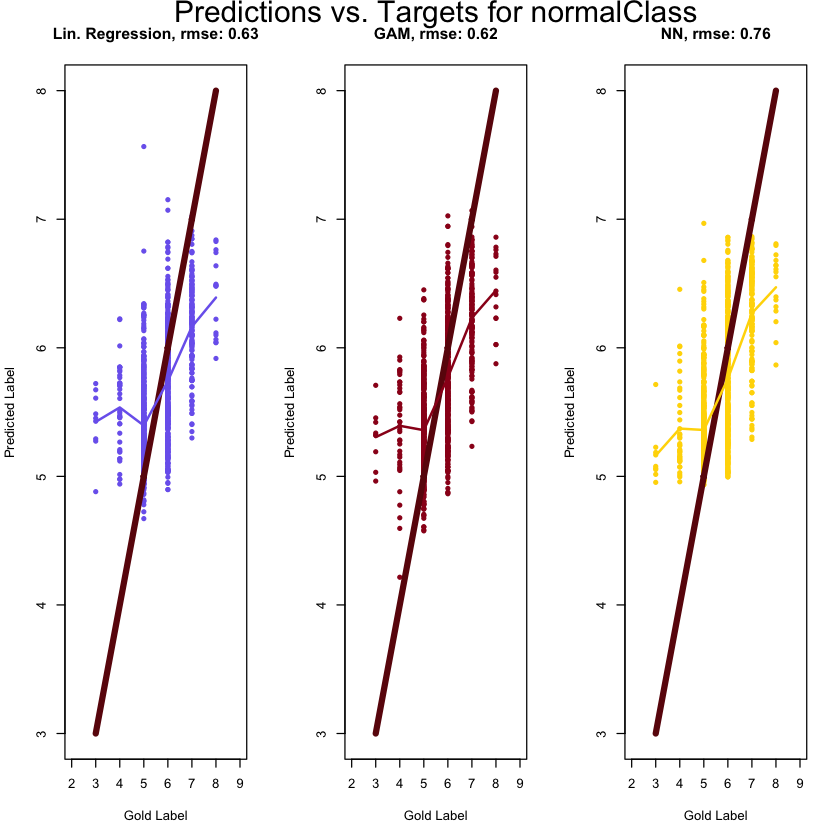

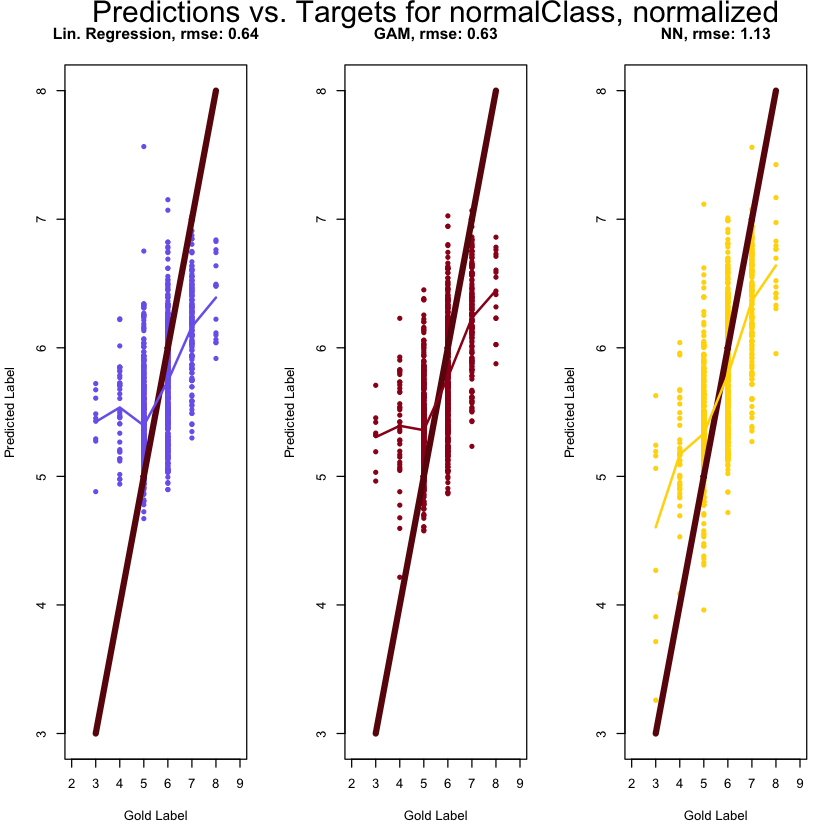

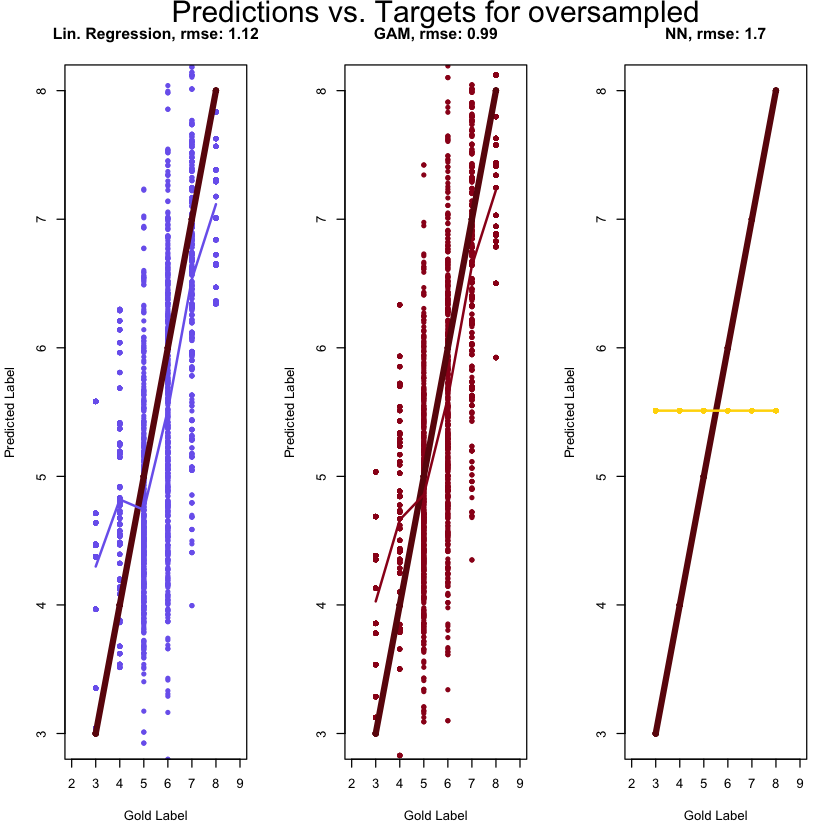

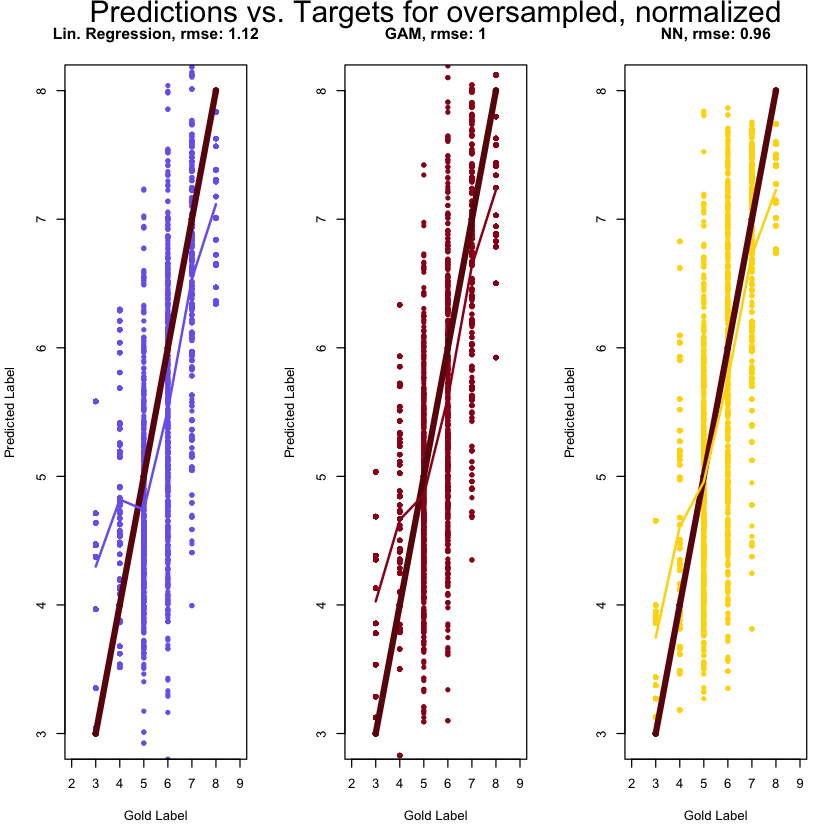

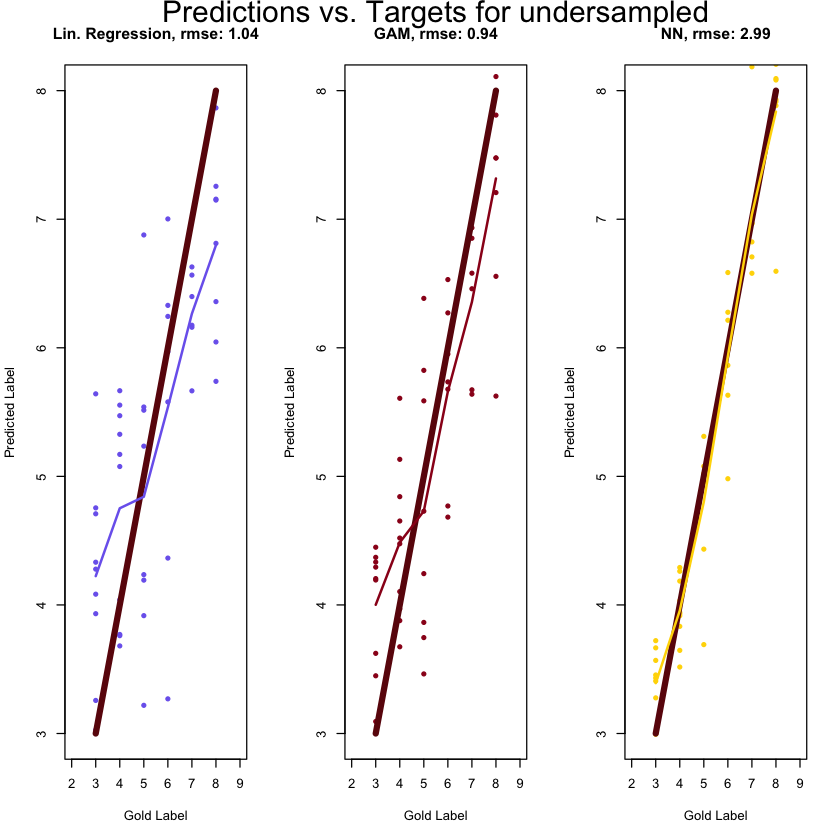

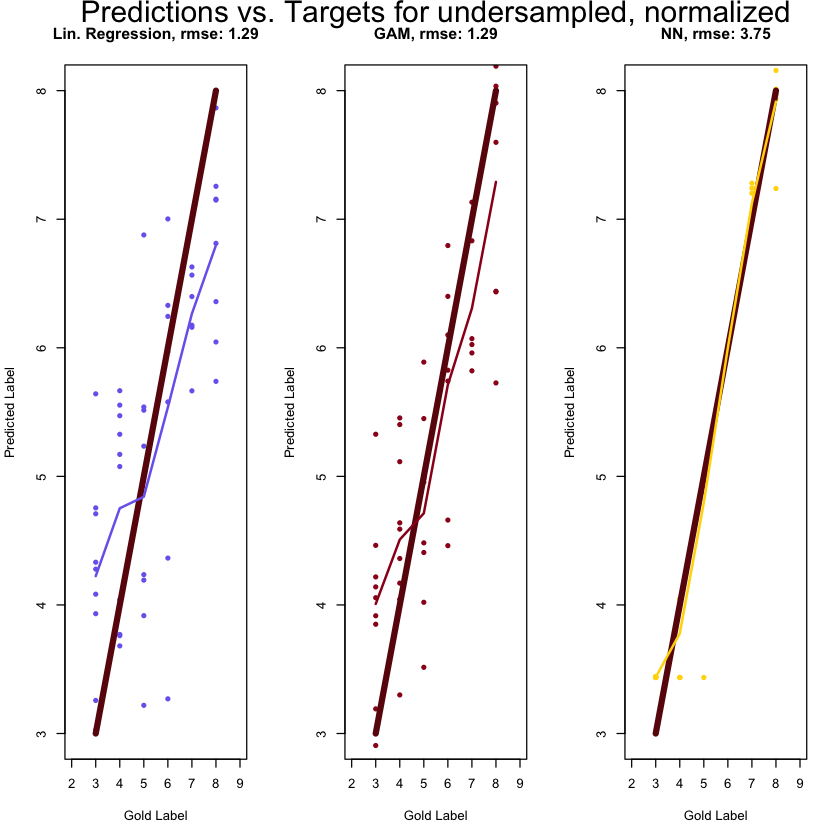

In [63]:
modelColor.gold <- "#6B0D0D"
modelColor.pred <- c("#7B68EE", "#9B111E", "#FFD700")

for(i in 1:length(files)){
    preds.train <- data.frame(gold = train_dfs[[i]]$quality,
                        LR = preds.train.LR[[i]],
                        GAM = preds.train.GAM[[i]],
                        NN = preds.train.NN[[i]])
    preds.train <- preds.train[order(preds.train$gold),]

    pred.means <- aggregate(. ~ gold, data = preds.train, FUN = mean)

    par(mfrow = c(1, 3))

    
    plot(preds.train$gold, preds.train$LR, col = modelColor.pred[1], pch = 20,
        xlim = c(2,9), ylim = c(3,8), xlab = "Gold Label", ylab = "Predicted Label",
        main = paste("Lin. Regression, rmse:", round(LR[i,3], 2)))
    lines(preds.train$gold, preds.train$gold, col = modelColor.gold, lw = 5)
    lines(pred.means$gold, pred.means$LR, col = modelColor.pred[1], lw = 2)

    plot(preds.train$gold, preds.train$GAM, col = modelColor.pred[2], pch = 20,
        xlim = c(2,9), ylim = c(3,8), xlab = "Gold Label", ylab = "Predicted Label",
        main = paste("GAM, rmse:", round(GAM[i,3], 2)))
    lines(preds.train$gold, preds.train$gold, col = modelColor.gold, lw = 5)
    lines(pred.means$gold, pred.means$GAM, col = modelColor.pred[2], lw = 2)

    if(grepl("normalized", files[i])){
        title <- paste("Predictions vs. Targets for ", files[i-1], ", normalized", sep = "")
    }
    else{
        title <- paste("Predictions vs. Targets for ", files[i], sep = "")
    }
    mtext(title, line = 2.56, cex = 1.5)

    plot(preds.train$gold, preds.train$NN, col = modelColor.pred[3], pch = 20,
        xlim = c(2,9), ylim = c(3,8), xlab = "Gold Label", ylab = "Predicted Label",
        main = paste("NN, rmse:", round(NN[i,3], 2)))
    lines(preds.train$gold, preds.train$gold, col = modelColor.gold, lw = 5)
    lines(pred.means$gold, pred.means$NN, col = modelColor.pred[3], lw = 2)
}




#### 4. Plot Gold vs. Best Predictions for Each Model

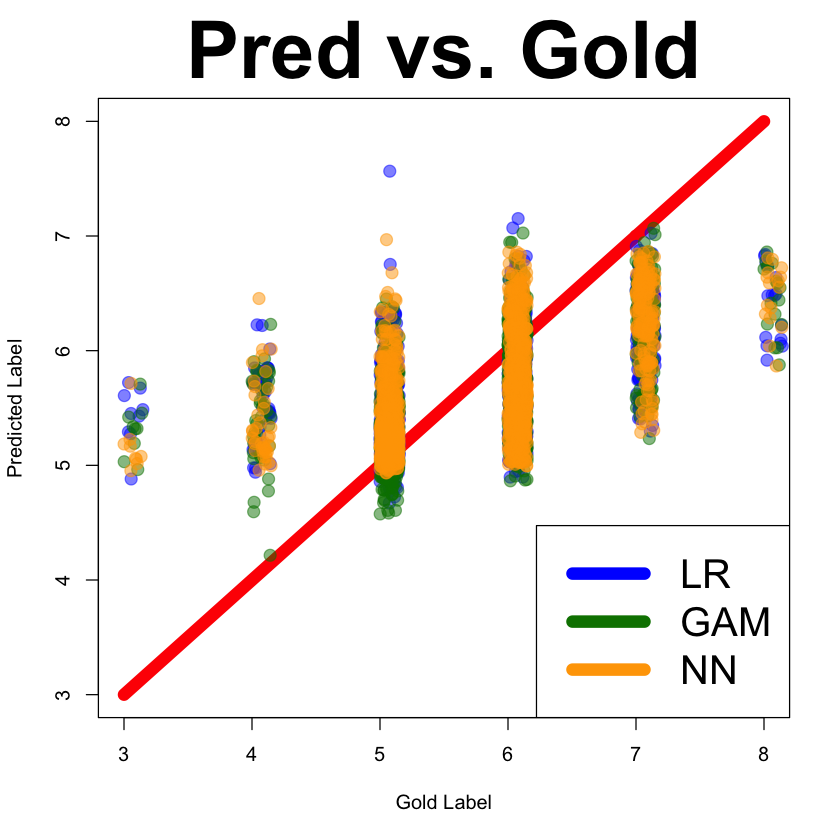

In [118]:
bestRMSE.LR <- Inf
LR.idx <- 0
bestRMSE.GAM <- Inf
GAM.idx <- 0
bestRMSE.NN <- Inf
NN.idx <- 0
for(i in 1:length(files)){
    if(LR[i,3] < bestRMSE.LR){
        bestRMSE.LR <- LR[i,3]
        LR.idx <- i
    }

    if(GAM[i,3] < bestRMSE.GAM){
        bestRMSE.GAM <- GAM[i,3]
        GAM.idx <- i
    }

    if(NN[i,3] < bestRMSE.NN){
        bestRMSE.NN <- NN[i,3]
        NN.idx <- i
    }
}

best.of.each <- data.frame(
    gold = train_dfs[[1]]$quality,
    LR = preds.train.LR[[LR.idx]],
    GAM = preds.train.GAM[[GAM.idx]],
    NN = preds.train.NN[[NN.idx]]
)
best.of.each <- best.of.each[order(best.of.each$gold),]

plot(best.of.each$gold, best.of.each$gold, type = "l", col = "red", lwd = 10,
     xlab = "Gold Label", ylab = "Predicted Label", main = "Pred vs. Gold", cex.main = 4)

colors <- c("#0000FF","#008000","#FFA500")

for(i in 2:4){
    color <- col2rgb(colors[i-1])/255
    points(best.of.each$gold + runif(nrow(best.of.each), min = 0, max = 0.15),
    (best.of.each[,i]), col = rgb(color[1],color[2],color[3], alpha = 0.5),
    pch = 20, cex = 2)
}
legend("bottomright", legend = c("LR","GAM","NN"), col = colors, lwd = 10, cex = 2)